# MobileViT Pruning

## Import Libraries

In [1]:
!pip install einops
!mkdir visualizations

In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.nn.utils import prune

import torchvision
from torchvision.transforms.transforms import RandomHorizontalFlip
from torchvision import datasets, transforms



In [3]:
def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)
    
    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))
        
        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x


### Helper Functions


In [4]:
def mobilevit_xxs():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((64, 64), dims, channels, num_classes=10, expansion=2)

def mobilevit_xs():
    dims = [96, 120, 144]
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
    return MobileViT((64, 64), dims, channels, num_classes=10)

def mobilevit_s():
    dims = [144, 192, 240]
    channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
    return MobileViT((64, 64), dims, channels, num_classes=10)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def train_valid_split(dataset, train_percentage: float = 0.8):
    
    dataset_size = dataset.__len__()

    train_count = int(dataset_size  * train_percentage)
    valid_count = dataset_size - train_count

    train_set, valid_set = torch.utils.data.random_split(dataset, [train_count, valid_count])

    print(f'Train Set: {train_set.__len__()}')
    print(f'Validation Set: {valid_set.__len__()}')
    print(f"Total: {train_set.__len__() + valid_set.__len__()}")

    return train_set, valid_set

In [6]:
standard_transform = transforms.Compose([
                            transforms.Resize(64),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
                            ])

test_transform = transforms.Compose([
                            transforms.Resize(64),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
                            ])

In [7]:
def plot_nonzero_accuracy(global_param, global_acc, struct_param, struct_acc, unstruct_param, unstruct_acc, model_size):
  plt.figure(figsize=(10,10))
  plt.plot(global_param, global_acc, color='blue', label='Global Pruning')
  plt.plot(struct_param, struct_acc, color='magenta', label='Structured Pruning')
  plt.plot(unstruct_param, unstruct_acc, color='green', label='Unstructured Pruning')
  plt.xlabel('# nonzero parameters')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.ylim([0, 100])
  plt.title(f'{model_size.upper()} MobileViT Pruning')
  plt.savefig(f'visualizations/pruning_techniques_param_acc.png', dpi=300)

def plot_train_validation(count, train_plot, valid_plot, model_size, dataset_name, type):
  plt.figure(figsize=(10,10))
  plt.plot(count, train_plot, color='blue', label='Train')
  plt.plot(count, valid_plot, color='magenta', label='Validation')
  plt.xlabel('Epochs')
  if type == 'Accuracy':
      plt.ylabel('Accuracy (%)')
  else:
      plt.ylabel('Loss')
  plt.legend()
  if type == 'Accuracy':
      plt.ylim([0, 100])
  plt.title(f'{model_size.upper()} MobileViT Training/Validation {type} - {dataset_name.upper()}')
  plt.savefig(f'visualizations/{model_size}_{dataset_name.lower()}_{type.lower()}.png', dpi=300)

In [8]:
'''
Structured Pruning - Pruning a larger part of the network (channel or layer)
    - filter pruning
'''
def prune_model_ln_structured(model, proportion = 0.5):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, 'weight', proportion, n=1, dim=1)
            prune.remove(module, 'weight')
        elif isinstance(module, nn.Linear):
            prune.ln_structured(module, 'weight', proportion, n=1, dim=1)
            prune.remove(module, 'weight')
    return model

'''
Unstructured Pruning - Find less salient connections and remove them
    - weight pruning
'''
def prune_model_l1_unstructured(model, proportion = 0.5):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
        elif isinstance(module, nn.Linear):
            if module.bias is not None:
                prune.l1_unstructured(module, 'bias', proportion)
                prune.remove(module, 'bias')

            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')

    return model

'''
Global Unstructured Pruning - removing across the whole model
    - Global Structured wouldn't make sense as a technique
'''
def prune_model_global_unstructured(model, proportion = .5):
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            parameters_to_prune.append((module, 'weight'))
        elif isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    
    prune.global_unstructured(parameters_to_prune, 
                              pruning_method = prune.L1Unstructured,
                              amount = proportion)

    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')
    return model

'''
Sparsity = 1 - (count_nonzero(model)/total_elements(model))
'''
def sparsity_calculation(model):
    total_zeros = 0
    total_nonzeros = 0
    total_param = 0
    for i in list(model.state_dict().values()):
        zeros = torch.sum(i == 0)
        non_zeros = torch.count_nonzero(i)
        total_zeros += int(zeros)
        total_nonzeros += int(non_zeros)
        total_param += int(non_zeros + zeros)

    sparsity = round(1 - float(total_nonzeros/total_param), 4)
    print(f"Non-Zero Parameters: {total_nonzeros}")
    print(f"Total Parameters: {total_param}")
    print(f"Sparsity: {sparsity}")
    
    return total_nonzeros

'''
Model Testing
'''
def test_model(model, test_loader):
    with torch.no_grad():
        test_correct = 0
        test_total = 0
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    return (100 * test_correct // test_total), test_total


### Configurations

In [9]:
BATCH_SIZE = 128
N_EPOCH = 50
LEARNING_RATE = 0.001

dataset_name = 'cifar10'
model_size = 'xxs'
training_set_allocation = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

unpruned_path = f"./unpruned_{model_size}_weights_{device}_{dataset_name}.pth"

print(unpruned_path)

./unpruned_xxs_weights_cuda_cifar10.pth


### Loading Dataset

In [10]:
if dataset_name == 'cifar10':
  print('Cifar10 Dataset Selected')
  dataset_train = datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=standard_transform)
  dataset_test = datasets.CIFAR10('./data/cifar10', train=False, download=True, transform=test_transform)
elif dataset_name == 'cifar100':
  print('Cifar100 Dataset Selected')
  dataset_train = datasets.CIFAR100('./data/cifar100', train=True, download=True, transform=standard_transform)
  dataset_test = datasets.CIFAR100('./data/cifar100', train=False, download=True, transform=test_transform)

Cifar10 Dataset Selected


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [11]:
train_set, valid_set = train_valid_split(dataset_train, training_set_allocation)
print(f'Test Set: {dataset_test.__len__()}')

Train Set: 40000
Validation Set: 10000
Total: 50000
Test Set: 10000


### Create DataLoaders

In [12]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = BATCH_SIZE,
                                           num_workers = 2,
                                           drop_last = True,
                                           shuffle = True
                                          )

valid_loader = torch.utils.data.DataLoader(valid_set,
                                           batch_size = BATCH_SIZE,
                                           num_workers = 2,
                                           drop_last = True,
                                           shuffle = True
                                          )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size = BATCH_SIZE,
                                          num_workers = 2,
                                          drop_last = True,
                                          shuffle = True
                                         )

### Model Instantiation

In [13]:
if model_size == 'xs': 
  model = mobilevit_xs()
elif model_size == 'xxs': 
  model = mobilevit_xxs()
else:
  if model_size != 's':
    print('Model Size does not exist - Default selected')
    model_size = 's'
  model = mobilevit_s()

model = model.to(device)    # Decide between GPU and CPU
print(f'MobileViT {model_size} on {device}: {count_parameters(model)} parameters')

MobileViT xxs on cuda: 1014672 parameters


# Training

Begin Training
Epoch 1
Epoch 1 	 Training Loss:   1.7062                               Training Acc:    0.4282
Epoch 1 	 Validation Loss: 1.5327                               Validation Acc:  0.5183
Saved better model
Epoch 2
Epoch 2 	 Training Loss:   1.4021                               Training Acc:    0.5831
Epoch 2 	 Validation Loss: 1.3657                               Validation Acc:  0.6037
Saved better model
Epoch 3
Epoch 3 	 Training Loss:   1.2529                               Training Acc:    0.6586
Epoch 3 	 Validation Loss: 1.2446                               Validation Acc:  0.6637
Saved better model
Epoch 4
Epoch 4 	 Training Loss:   1.1595                               Training Acc:    0.7016
Epoch 4 	 Validation Loss: 1.1646                               Validation Acc:  0.6988
Saved better model
Epoch 5
Epoch 5 	 Training Loss:   1.0918                               Training Acc:    0.7362
Epoch 5 	 Validation Loss: 1.1309                               Validation Ac

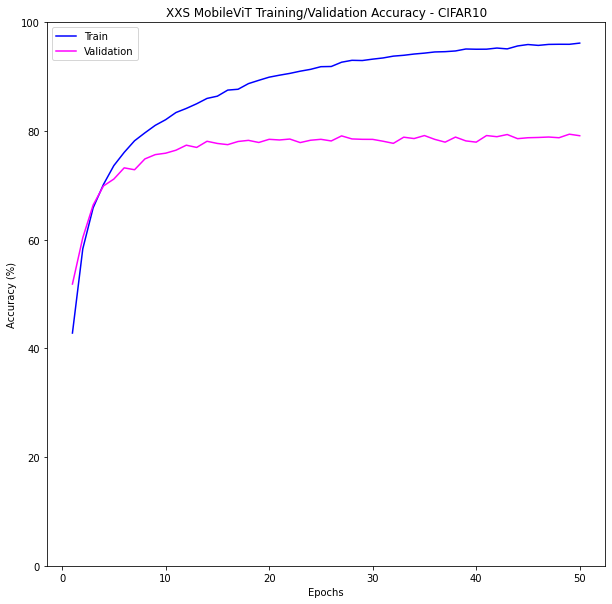

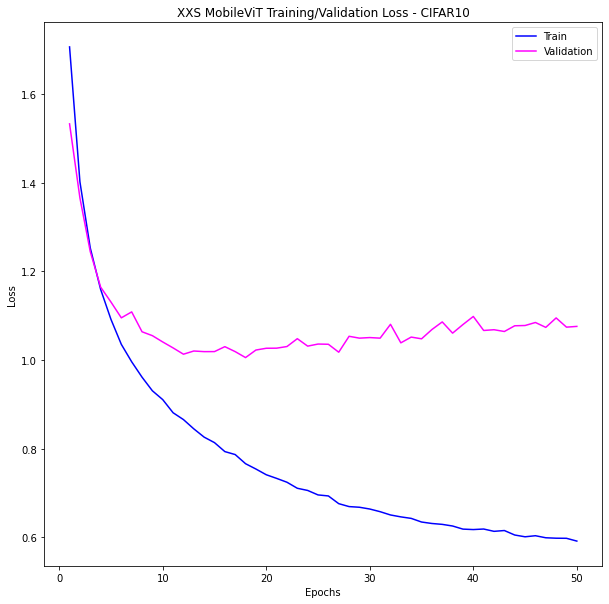

In [14]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE)

### Define Lists for visualizations
train_loss_plot = []
train_acc_plot = []
valid_loss_plot = []
valid_acc_plot = []

print("Begin Training")
best_accuracy = 0

t1 = time.perf_counter()
for epoch in range(N_EPOCH):
  print(f"Epoch {epoch+1}")
  train_loss = 0.0
  train_correct = 0
  train_total = 0
  model.train()
  
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)

    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  valid_loss = 0.0
  valid_correct = 0
  valid_total = 0
  model.eval()
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)

    valid_total += labels.size(0)
    valid_correct += (predicted == labels).sum().item()
    valid_loss += loss.item()

  print(f'Epoch {epoch + 1} \t Training Loss:   {(train_loss / len(train_loader)):.4f} \
                              Training Acc:    {(train_correct / train_total):.4f}')
  print(f'Epoch {epoch + 1} \t Validation Loss: {(valid_loss / len(valid_loader)):.4f} \
                              Validation Acc:  {(valid_correct / valid_total):.4f}')

  train_loss_plot.append(round(train_loss / len(train_loader), 4))
  train_acc_plot.append(round(100 * (train_correct / train_total), 4))
  valid_loss_plot.append(round(valid_loss / len(valid_loader), 4))
  valid_acc_plot.append(round(100 * (valid_correct / valid_total), 4))

  current_accuracy = 100 * (valid_correct / valid_total)
  if current_accuracy > best_accuracy:
    print("Saved better model")
    best_accuracy = current_accuracy
    torch.save(model.state_dict(), unpruned_path)
  else:
    print("Not saved")
        
t2 = time.perf_counter()

print(f"Finished Training in {int(t2 - t1)} seconds")

epoch_count = range(1, N_EPOCH + 1)
plot_train_validation(epoch_count, train_acc_plot, valid_acc_plot, model_size, dataset_name ,'Accuracy')
plot_train_validation(epoch_count, train_loss_plot, valid_loss_plot, model_size, dataset_name, 'Loss')

In [15]:
print("Begin Testing")
model.load_state_dict(torch.load(unpruned_path))

test_correct = 0
test_total = 0

with torch.no_grad():
  for i, data in enumerate(test_loader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

print(f'Accuracy of unpruned network on {test_total} test images: {100 * test_correct // test_total}%')

Begin Testing
Accuracy of unpruned network on 9984 test images: 79%


# Pruning

In [16]:
global_nz_param_plot = []
global_acc_plot = []
print("Begin Global Pruning")
for i in range(20):
  model.load_state_dict(torch.load(unpruned_path))
  model = prune_model_global_unstructured(model, i * 0.05)
  non_zeros = sparsity_calculation(model)
  global_nz_param_plot.append(non_zeros)

  # torch.save(model.state_dict(), f"./saved_models/test/pruned_global_weights{i*5}.pth")

  accuracy, test_total = test_model(model, test_loader)
  global_acc_plot.append(accuracy)

  print(f'Global - Accuracy of pruned network {i*5}%: {accuracy}%')

Begin Global Pruning
Non-Zero Parameters: 1019299
Total Parameters: 1019299
Sparsity: 0.0
Global - Accuracy of pruned network 0%: 79%
Non-Zero Parameters: 969150
Total Parameters: 1019299
Sparsity: 0.0492
Global - Accuracy of pruned network 5%: 79%
Non-Zero Parameters: 919001
Total Parameters: 1019299
Sparsity: 0.0984
Global - Accuracy of pruned network 10%: 79%
Non-Zero Parameters: 868853
Total Parameters: 1019299
Sparsity: 0.1476
Global - Accuracy of pruned network 15%: 79%
Non-Zero Parameters: 818704
Total Parameters: 1019299
Sparsity: 0.1968
Global - Accuracy of pruned network 20%: 79%
Non-Zero Parameters: 768555
Total Parameters: 1019299
Sparsity: 0.246
Global - Accuracy of pruned network 25%: 79%
Non-Zero Parameters: 718406
Total Parameters: 1019299
Sparsity: 0.2952
Global - Accuracy of pruned network 30%: 79%
Non-Zero Parameters: 668257
Total Parameters: 1019299
Sparsity: 0.3444
Global - Accuracy of pruned network 35%: 79%
Non-Zero Parameters: 618109
Total Parameters: 1019299
Sp

In [17]:
struct_nz_param_plot = []
struct_acc_plot = []
print("Begin Unstructured Pruning")
for i in range(20):
  model.load_state_dict(torch.load(unpruned_path))
  model = prune_model_ln_structured(model, i * 0.05)
  non_zeros = sparsity_calculation(model)
  struct_nz_param_plot.append(non_zeros)

  # torch.save(model.state_dict(), f"./saved_models/test/pruned_struct_weights{i*5}.pth")

  accuracy, test_total = test_model(model, test_loader)
  struct_acc_plot.append(accuracy)

  print(f'Structured - Accuracy of pruned network {i*5}%: {accuracy}%')


Begin Unstructured Pruning
Non-Zero Parameters: 1019299
Total Parameters: 1019299
Sparsity: 0.0
Structured - Accuracy of pruned network 0%: 79%
Non-Zero Parameters: 969571
Total Parameters: 1019299
Sparsity: 0.0488
Structured - Accuracy of pruned network 5%: 72%
Non-Zero Parameters: 919147
Total Parameters: 1019299
Sparsity: 0.0983
Structured - Accuracy of pruned network 10%: 47%
Non-Zero Parameters: 869787
Total Parameters: 1019299
Sparsity: 0.1467
Structured - Accuracy of pruned network 15%: 29%
Non-Zero Parameters: 819219
Total Parameters: 1019299
Sparsity: 0.1963
Structured - Accuracy of pruned network 20%: 13%
Non-Zero Parameters: 769491
Total Parameters: 1019299
Sparsity: 0.2451
Structured - Accuracy of pruned network 25%: 10%
Non-Zero Parameters: 719763
Total Parameters: 1019299
Sparsity: 0.2939
Structured - Accuracy of pruned network 30%: 10%
Non-Zero Parameters: 669339
Total Parameters: 1019299
Sparsity: 0.3433
Structured - Accuracy of pruned network 35%: 10%
Non-Zero Paramete

In [18]:
unstruct_nz_param_plot = []
unstruct_acc_plot = []
print("Begin Unstructured Pruning")
for i in range(20):
  model.load_state_dict(torch.load(unpruned_path))
  model = prune_model_l1_unstructured(model, i * 0.05)
  non_zeros = sparsity_calculation(model)
  unstruct_nz_param_plot.append(non_zeros)

  # torch.save(model.state_dict(), f"./saved_models/test/pruned_unstruct_weights{i*5}.pth")

  accuracy, test_total = test_model(model, test_loader)
  unstruct_acc_plot.append(accuracy)

  print(f'Unstructured - Accuracy of pruned network {i*5}%: {accuracy}%')

Begin Unstructured Pruning
Non-Zero Parameters: 1019299
Total Parameters: 1019299
Sparsity: 0.0
Unstructured - Accuracy of pruned network 0%: 79%
Non-Zero Parameters: 968938
Total Parameters: 1019299
Sparsity: 0.0494
Unstructured - Accuracy of pruned network 5%: 79%
Non-Zero Parameters: 918592
Total Parameters: 1019299
Sparsity: 0.0988
Unstructured - Accuracy of pruned network 10%: 79%
Non-Zero Parameters: 868222
Total Parameters: 1019299
Sparsity: 0.1482
Unstructured - Accuracy of pruned network 15%: 79%
Non-Zero Parameters: 817876
Total Parameters: 1019299
Sparsity: 0.1976
Unstructured - Accuracy of pruned network 20%: 77%
Non-Zero Parameters: 767515
Total Parameters: 1019299
Sparsity: 0.247
Unstructured - Accuracy of pruned network 25%: 75%
Non-Zero Parameters: 717154
Total Parameters: 1019299
Sparsity: 0.2964
Unstructured - Accuracy of pruned network 30%: 68%
Non-Zero Parameters: 666808
Total Parameters: 1019299
Sparsity: 0.3458
Unstructured - Accuracy of pruned network 35%: 58%
No

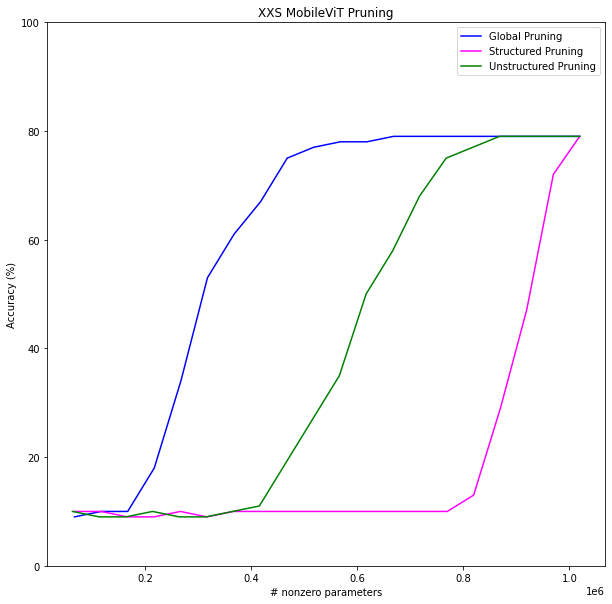

In [19]:
plot_nonzero_accuracy(global_nz_param_plot, global_acc_plot,
                      struct_nz_param_plot, struct_acc_plot,
                      unstruct_nz_param_plot, unstruct_acc_plot,
                      model_size
                      )